# Visu 1

04/04/2024

Chargement d'un modèle préentrainé (AlexNet, VGG16, ...) et visualisation des activations intermédiaires (dont les cartes de caractéristiques).

## Modules

In [1]:
import os
import json
import math
from functools import partial
from typing import Any, Tuple, List

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torchvision.transforms as T
import torchvision.transforms.functional as F
from torchvision.io import read_image

from torchinfo import summary
#plt.rcParams["savefig.bbox"] = 'tight'

## Device

In [2]:
################@
def get_best_device():
    if torch.cuda.is_available():
        # move models to GPU
        device = torch.device("cuda")
        print('CUDA GPU available for training. Models moved to CUDA GPU')
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print('MPS GPU available for training. Models moved to MPS GPU')
    else:
        device = torch.device("cpu")
        print('Training on CPU')
    return device
device = get_best_device()

MPS GPU available for training. Models moved to MPS GPU


## Utils

### `show_images`

source : [Pytorch Doc - Visualization utilities](https://pytorch.org/vision/main/auto_examples/others/plot_visualization_utils.html#sphx-glr-auto-examples-others-plot-visualization-utils-py)

idée : ajouter la gestion des lignes

> UTILE ?

In [3]:
def show_images(images, title=""):
    """ Display a raw of images"""
    if not isinstance(images, list):
        images = [images]
    fig, axs = plt.subplots(ncols=len(images), squeeze=False)
    for i, img in enumerate(images):
        #img = img.detach()
        #img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

### `get_conv_def`

Retourne un dictionnaire des principaux paramètres d'un module PyTorch Conv2d

In [4]:
def get_conv_def(conv: nn.Conv2d) -> dict:
    """ """
    get_keys = ["in_channels", "out_channels", "kernel_size", "stride", "padding", "padding_mode", "dilation", "bias"]
    values = vars(conv)
    return {k:(values[k] if k in values else None) for k in get_keys}

### `conv2d_output_size`

Calcul de la taille de la sortie d'un conv2d selon ses paramètres et la taille de l'entrée

In [5]:
def conv2d_output_size(
        input_size: int|Tuple[int, int],
        kernel_size: int|Tuple[int, int],
        padding_size: int|Tuple[int, int]=0,
        stride_size: int|Tuple[int, int]=1,
        dilation_size: int|Tuple[int, int]=1,
        pooling_size: int|Tuple[int, int]=1
        ):
    """ """
    _to_tuple = lambda v: (v, v)
    
    if type(input_size) == int:
        input_size = _to_tuple(input_size)
    elif type(input_size) == dict:
        input_size = (input_size["height"], input_size["width"])
    
    if type(kernel_size) == int:
        kernel_size = _to_tuple(kernel_size)
    
    if type(padding_size) == int:
        padding_size = _to_tuple(padding_size)

    if type(stride_size) == int:
        stride_size = _to_tuple(stride_size)
    
    if type(dilation_size) == int:
        dilation_size = _to_tuple(dilation_size)
    
    if type(pooling_size) == int:
        pooling_size = _to_tuple(pooling_size)

    output_size = lambda i: math.floor((
         (input_size[i] + 2 * padding_size[i] - dilation_size[i] * (kernel_size[i] - 1) - 1) / stride_size[i] + 1) / pooling_size[i]
         )
    output_size_h = output_size(0)
    output_size_w = output_size(1)
    return {"height": output_size_h, "width": output_size_w}

## Modèles

In [6]:
cnn_models = {}

### Alexnet + IMAGENET1K_V1

source(s): 
- https://pytorch.org/vision/stable/models/generated/torchvision.models.alexnet.html#torchvision.models.AlexNet_Weights
- https://pytorch.org/hub/pytorch_vision_alexnet/

In [7]:
cnn_models["alexet"] = models.alexnet(weights='IMAGENET1K_V1')
cnn_models["alexet"].eval()
cnn_models["alexet"].features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [8]:
#type(model.features[0])
#vars(model.features[0])
#model.features[0].weight.size()
cnn_models["alexet"].features[3].weight.size()

torch.Size([192, 64, 5, 5])

In [9]:
vars(cnn_models["alexet"].features[3])

{'training': False,
 '_parameters': OrderedDict([('weight',
               Parameter containing:
               tensor([[[[ 3.6245e-03,  1.4335e-03,  3.7217e-02, -2.0926e-02,  1.8121e-03],
                         [ 2.4126e-02, -1.2056e-02,  7.1170e-02, -8.5224e-02,  1.3067e-02],
                         [ 2.0966e-02, -1.0623e-01,  2.1572e-02, -6.9547e-02,  3.1583e-02],
                         [-8.3392e-03, -3.9020e-02, -4.6621e-02,  2.2133e-02, -1.3252e-03],
                         [-1.5370e-02,  8.6569e-03,  3.1479e-02,  1.6698e-02, -4.7130e-03]],
               
                        [[-5.4573e-03, -1.9087e-02, -3.2424e-02, -2.2006e-02, -1.2120e-02],
                         [-7.4972e-03,  3.0946e-02,  3.1899e-02, -7.6327e-03, -1.4720e-02],
                         [ 5.4830e-03,  8.0306e-02,  6.1262e-02,  1.3252e-02,  2.6240e-02],
                         [-2.6938e-02,  5.9188e-03,  3.8373e-02, -6.3116e-03,  3.9863e-03],
                         [ 2.0844e-03, -3.6292e-02, -2.198

In [10]:
summary(cnn_models["alexet"], input_size=torch.Size([1, 3, 224, 224]))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

In [11]:
summary(cnn_models["alexet"].features, input_size=torch.Size([1, 3, 224, 224]))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 256, 6, 6]            --
├─Conv2d: 1-1                            [1, 64, 55, 55]           23,296
├─ReLU: 1-2                              [1, 64, 55, 55]           --
├─MaxPool2d: 1-3                         [1, 64, 27, 27]           --
├─Conv2d: 1-4                            [1, 192, 27, 27]          307,392
├─ReLU: 1-5                              [1, 192, 27, 27]          --
├─MaxPool2d: 1-6                         [1, 192, 13, 13]          --
├─Conv2d: 1-7                            [1, 384, 13, 13]          663,936
├─ReLU: 1-8                              [1, 384, 13, 13]          --
├─Conv2d: 1-9                            [1, 256, 13, 13]          884,992
├─ReLU: 1-10                             [1, 256, 13, 13]          --
├─Conv2d: 1-11                           [1, 256, 13, 13]          590,080
├─ReLU: 1-12                             [1, 256, 13, 13]    

## Accès à des images extraites de ImageNet
source(s) :
- https://github.com/EliSchwartz/imagenet-sample-images
- https://huggingface.co/datasets/imagenet-1k/viewer/default/validation

In [12]:
with open("imagenet_labels.json") as f:
    labels = json.load(f)
labels

{'0': 'tench, Tinca tinca',
 '1': 'goldfish, Carassius auratus',
 '2': 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 '3': 'tiger shark, Galeocerdo cuvieri',
 '4': 'hammerhead, hammerhead shark',
 '5': 'electric ray, crampfish, numbfish, torpedo',
 '6': 'stingray',
 '7': 'cock',
 '8': 'hen',
 '9': 'ostrich, Struthio camelus',
 '10': 'brambling, Fringilla montifringilla',
 '11': 'goldfinch, Carduelis carduelis',
 '12': 'house finch, linnet, Carpodacus mexicanus',
 '13': 'junco, snowbird',
 '14': 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 '15': 'robin, American robin, Turdus migratorius',
 '16': 'bulbul',
 '17': 'jay',
 '18': 'magpie',
 '19': 'chickadee',
 '20': 'water ouzel, dipper',
 '21': 'kite',
 '22': 'bald eagle, American eagle, Haliaeetus leucocephalus',
 '23': 'vulture',
 '24': 'great grey owl, great gray owl, Strix nebulosa',
 '25': 'European fire salamander, Salamandra salamandra',
 '26': 'common newt, Triturus vulga

255


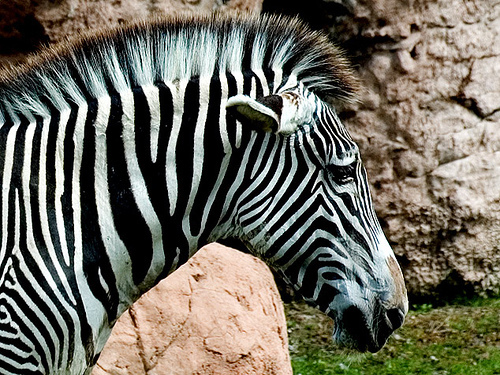

In [13]:
DataPath = "/Users/me/Documents/Work/Dev/_data/imagenet-sample-images-master"
ImageFile = "n02391049_zebra.JPEG"
filename = os.path.join(DataPath, ImageFile)
input_image = read_image(filename)
img = T.functional.to_pil_image(input_image)

print(input_image.max().item())
img

In [14]:
# Source : https://pytorch.org/vision/main/models/generated/torchvision.models.alexnet.html
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

## Classe `CNNFeaturesHandler`

Classe de manipulation d'un réseau CNN

### Définition

In [15]:
class CNNFeaturesHandler():
    """ """
    def __init__(self, model_features: list[nn.Module]|nn.Sequential):
        """ New instance initialization """
        # nn.ModuleList(model_features)
        if not isinstance(model_features, nn.Sequential):
            self.model_features = nn.Sequential(model_features)
        else:
            self.model_features = model_features
        self.model_summary = None

    def assert_correct_layer_idx(self, idx: int) -> None:
        assert self.is_correct_idx(idx), f"Layer index (idx = {idx}) must be in range [0, {len(self.model_features)})"


    def get_conv_layers_count(self):
        """
        Returns the number of conv layer in the feature part of the model
        """
        return len(self.get_conv_indexes())


    def get_conv_def(self, conv_pos: int):
        """ 
        Returns the layer corresponding to the conv layer at pos conv_pos in the features part of the model
        """
        return get_conv_def(self.get_conv_layer(conv_pos))


    def get_conv_filters(self, conv_pos: int) -> torch.Tensor:
        """
        Returns filters parameters a.k.a weights of the conv layer at pos conv_pos in the features part of the model
        """
        conv = self.get_conv_layer(conv_pos)

        return conv.weight


    def get_conv_layer(self, conv_pos: int) -> nn.Conv2d:
        """
        Returns the conv layer at pos conv_pos in the features part of the model
        """
        index = self.get_conv_index(conv_pos)

        return self.get_feature_layer(index)
    

    def get_conv_index(self, conv_pos: int) -> int:
        """ 
        - Argument(s)
            i : int
                i-th conv layer position order in model feature layer list
        - Return(s)
            idx : int
                index of conv layer position in model feature layer list
        """
        conv_indexes = self.get_conv_indexes()
        len_conv_indexes = len(conv_indexes)
        assert conv_pos in range(1, len_conv_indexes + 1), f"Layer position (conv_pos = {conv_pos}) must be in range [1, {len_conv_indexes}]"

        return conv_indexes[conv_pos-1]


    def get_conv_indexes(self):
        """
        Returns list of indexes of each conv layer in the features part of the model
        """
        return [idx for idx, layer in enumerate(self.model_features) if isinstance(layer, nn.Conv2d)]


    def get_conv_output(self, x: torch.Tensor, conv_pos: int, keep_previous=False) -> torch.Tensor:
        """
        - Argument(s)
            conv_pos : int
                Position de la couche entre 1 et le nombre de couches de conv (pas l'indice dans l'ensemble des couches de la partie features du modele)
        """
        idx = self.get_conv_index(conv_pos)

        return self.get_feature_layer_output(x, idx, keep_previous=keep_previous)


    def get_feature_layer(self, idx: int) -> nn.Module:
        """

        """
        idx = self.get_normalized_idx(idx)
        self.assert_correct_layer_idx(idx)

        return self.model_features[idx]
    

    def get_feature_layer_output(self, x: torch.Tensor, layer_idx: int=-1, keep_previous: bool=False, verbose: bool=False) -> torch.Tensor:
        """
        Returns output of a specific layer of feature part of the model, and each previous layer output if required

        - Argument(s):
            x : torch.Tensor
                input data
            idx : int
                idex of the layer. -1 : last one
            keep_previous : bool
                list of output each layer, if required (default: False)
        - Return(s)
            x : torch.Tensor
                stack output (last features layer stack output)
            outputs : None|[torch.Tensor]
                If required, list of each layer output
        """
        layer_idx = self.get_normalized_idx(layer_idx)
        self.assert_correct_layer_idx(layer_idx)

        outputs = [] if keep_previous else None
        with torch.no_grad():
            for idx, layer in enumerate(self.model_features):
                layer.eval()
                x = layer(x)
                if keep_previous:
                    outputs.append(x)
                if idx == layer_idx:
                    break;
        
            if verbose:
                print(x.size(), f"after {idx}", layer)
        return x, outputs

    
    def get_feature_layer_summary(self,  idx: int=-1, raise_exception: bool=True):
        """
        """
        if not self.model_summary:
            msg = "Process summary first calling '.summary()'"
            if raise_exception:
                raise IndexError(msg)
            else:
                print(msg)
                return None
        
        idx = self.get_normalized_idx(idx)
        self.assert_correct_layer_idx(idx)

        ## Because of nn.Sequential is the first of summary
        if isinstance(self.model_features, nn.Sequential):
            idx = idx + 1

        return self.model_summary.summary_list[idx].output_size


    def get_features_output(self, x, keep_previous=False):
        """
        Returns output of features part of the model , and each layer output if required
        
        - Argument(s):
            x : torch.Tensor
                input data
            keep_previous : bool
                list of output each layer, if required (default: False)
        - Return(s)
            x : torch.Tensor
                stack output (last features layer stack output)
            outputs : None|[torch.Tensor]
                If required, list of each layer output
        """
        return self.get_feature_layer_output(x, keep_previous=keep_previous)
    

    def get_normalized_idx(self, layer_idx: int=-1):
        if layer_idx < 0:
            layer_idx = len(self.model_features) + layer_idx
        
        return layer_idx


    def is_correct_idx(self, idx: int) -> bool:
        """
        Check if idx is in the range of the feature part of the model
        """
        return idx in range(len(self.model_features))


    def show_conv_list(self, input_size=(100, 100)):
        """ """
        conv_indexes = self.get_conv_indexes()
        for pos, idx in enumerate(conv_indexes, start=1):
            args = self.get_conv_def(pos)
            output_size = conv2d_output_size(
                input_size=input_size,
                kernel_size=args["kernel_size"],
                padding_size=args["padding"],
                stride_size=args["stride"],
                dilation_size=args["dilation"]
            )

            print(f"idx: {idx:3d} -", self.get_conv_layer(pos), f"putput size : {output_size}")


    def show_feature_list(self):
        for idx, layer in enumerate(self.model_features):
            print(f"idx: {idx:3d} -", layer)


    def summary(self, input_batch_size=torch.Size([1, 3, 224, 224]), verbose=True):
        """
        Display summary of the feature part of the model
        """
        print("input size:", input_batch_size)
        self.model_summary = summary(self.model_features, input_size=input_batch_size)
        if verbose:
            print(self.model_summary)

### Tests de `CNNFeaturesHandler`

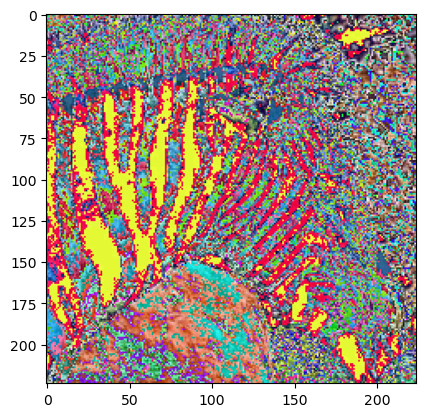

min: -2.1179039478302 | max: 2.640000104904175 | shape: torch.Size([3, 224, 224])


In [16]:
# Load and transform an ImageNet image
imagenet_preprocess = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.Lambda(lambda t: t/255.),
    #T.ToTensor(),
    T.Normalize(mean=imagenet_mean, std=imagenet_std),
])
input_tensor = imagenet_preprocess(input_image)
plt.imshow(F.to_pil_image(input_tensor))
plt.show()
print(f"min: {input_tensor.min()} | max: {input_tensor.max()} | shape: {input_tensor.size()}")

In [17]:

input_batch = input_tensor.unsqueeze(0)

In [18]:
print("input size:", input_batch.size())
summary(cnn_models["alexet"], input_size=input_batch.size())

input size: torch.Size([1, 3, 224, 224])


Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

In [19]:
summary(cnn_models["alexet"].features, input_size=input_batch.size())

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 256, 6, 6]            --
├─Conv2d: 1-1                            [1, 64, 55, 55]           23,296
├─ReLU: 1-2                              [1, 64, 55, 55]           --
├─MaxPool2d: 1-3                         [1, 64, 27, 27]           --
├─Conv2d: 1-4                            [1, 192, 27, 27]          307,392
├─ReLU: 1-5                              [1, 192, 27, 27]          --
├─MaxPool2d: 1-6                         [1, 192, 13, 13]          --
├─Conv2d: 1-7                            [1, 384, 13, 13]          663,936
├─ReLU: 1-8                              [1, 384, 13, 13]          --
├─Conv2d: 1-9                            [1, 256, 13, 13]          884,992
├─ReLU: 1-10                             [1, 256, 13, 13]          --
├─Conv2d: 1-11                           [1, 256, 13, 13]          590,080
├─ReLU: 1-12                             [1, 256, 13, 13]    

##### `.__init__()`

In [20]:
model_features = cnn_models["alexet"].features
features_handler = CNNFeaturesHandler(model_features)

##### `.is_correct_idx()`

In [21]:
print("idx=0", features_handler.is_correct_idx(0))
print("idx=1", features_handler.is_correct_idx(1))
print("idx=100", features_handler.is_correct_idx(100))

idx=0 True
idx=1 True
idx=100 False


##### `.get_feature_layer()`

In [22]:
print(features_handler.get_feature_layer(1))
try:
    print(features_handler.get_feature_layer(100)) # Exception raised
except AssertionError as err:
    print("Error: {}".format(err))

ReLU(inplace=True)
Error: Layer index (idx = 100) must be in range [0, 13)


##### `.get_conv_indexes()`

In [23]:
features_handler.get_conv_indexes()

[0, 3, 6, 8, 10]

#### `.get_conv_layers_count`

In [24]:
features_handler.get_conv_layers_count()

5

#### `.get_conv_index()`

In [25]:
print(features_handler.get_conv_index(1))
print(features_handler.get_conv_index(3))
try:
    print(features_handler.get_conv_index(10)) # Exception raised
except AssertionError as err:
    print("Error: {}".format(err))

0
6
Error: Layer position (conv_pos = 10) must be in range [1, 5]


#### `.get_conv_layer()`

In [26]:
features_handler.get_conv_layer(3)

Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

#### `.get_conv_def()`

In [27]:
features_handler.get_conv_def(1)

{'in_channels': 3,
 'out_channels': 64,
 'kernel_size': (11, 11),
 'stride': (4, 4),
 'padding': (2, 2),
 'padding_mode': 'zeros',
 'dilation': (1, 1),
 'bias': None}

#### `.show_conv_list()`

In [28]:
features_handler.show_conv_list()

idx:   0 - Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)) putput size : {'height': 24, 'width': 24}
idx:   3 - Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) putput size : {'height': 100, 'width': 100}
idx:   6 - Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) putput size : {'height': 100, 'width': 100}
idx:   8 - Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) putput size : {'height': 100, 'width': 100}
idx:  10 - Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) putput size : {'height': 100, 'width': 100}


#### `.get_conv_filters()`

In [29]:
features_handler.get_conv_filters(3)

Parameter containing:
tensor([[[[ 2.4858e-02,  1.3116e-02,  2.8198e-02],
          [ 4.2541e-02,  5.7339e-02, -6.0905e-03],
          [-4.1912e-03,  9.3096e-03, -1.5442e-02]],

         [[-3.8954e-03, -7.8586e-02, -5.1808e-02],
          [ 2.6484e-02, -4.9877e-02, -1.7763e-03],
          [ 8.2902e-03, -4.9339e-02,  3.1145e-02]],

         [[ 1.6455e-02, -1.2150e-02,  1.7428e-02],
          [ 5.2012e-02, -6.7141e-03,  2.7325e-02],
          [ 7.5568e-03, -4.2402e-02, -2.7909e-02]],

         ...,

         [[-1.7289e-04,  2.4099e-02,  3.6948e-02],
          [-2.4145e-02, -3.5276e-02,  3.6910e-03],
          [ 1.9541e-02, -3.0342e-02, -3.5262e-02]],

         [[ 1.3239e-02, -1.8624e-02, -5.3330e-02],
          [ 1.7639e-04, -1.4714e-02, -2.2829e-02],
          [-6.7702e-03,  2.3287e-02,  1.3873e-02]],

         [[ 3.0512e-02,  7.5860e-03,  4.9459e-04],
          [-4.5703e-03, -1.2827e-02, -6.5061e-03],
          [-9.8111e-03, -1.5570e-02,  1.9379e-02]]],


        [[[ 1.3660e-02, -3.9180

#### `.get_feature_layer_output()`

In [30]:
output, previous_outputs = features_handler.get_feature_layer_output(input_batch, 0)
print("output", output)
print("outputs", previous_outputs)

output tensor([[[[ 8.5480e-02, -3.1983e+00, -3.5679e+00,  ..., -3.3571e+00,
            5.3969e-01, -4.0298e-01],
          [-5.4527e+00, -3.0877e+00, -1.7928e+00,  ..., -2.1355e+00,
           -5.4081e+00,  2.8825e+00],
          [-1.4860e+00,  7.6847e-01,  2.1285e+00,  ...,  2.9984e+00,
            6.8512e+00,  2.2905e+00],
          ...,
          [ 2.2302e+00,  9.2433e-01, -1.9552e+00,  ...,  7.5442e+00,
           -2.5382e+00, -2.2381e+00],
          [ 6.8452e-01,  3.4481e+00, -2.6279e+00,  ..., -2.2106e+00,
           -2.0482e+00,  4.0533e+00],
          [ 2.7776e-01,  3.7936e+00, -2.8009e+00,  ..., -1.7577e+00,
            2.5585e-01, -6.4954e-01]],

         [[-4.1459e+00, -3.8572e+00, -3.5370e+00,  ..., -3.9229e+00,
           -6.2173e+00,  1.0740e+00],
          [-4.5414e+00, -2.5921e+00, -7.7452e-01,  ..., -8.6426e-01,
           -4.9362e+00, -4.0451e+00],
          [ 6.7890e-01,  1.0009e+00,  8.3201e-01,  ...,  1.7477e+00,
            5.0979e-01, -8.3042e+00],
          ...

In [31]:
output, previous_outputs = features_handler.get_feature_layer_output(input_batch, 1, keep_previous=True)
print("output", output)
print("outputs", previous_outputs)

output tensor([[[[0.0855, 0.0000, 0.0000,  ..., 0.0000, 0.5397, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.8825],
          [0.0000, 0.7685, 2.1285,  ..., 2.9984, 6.8512, 2.2905],
          ...,
          [2.2302, 0.9243, 0.0000,  ..., 7.5442, 0.0000, 0.0000],
          [0.6845, 3.4481, 0.0000,  ..., 0.0000, 0.0000, 4.0533],
          [0.2778, 3.7936, 0.0000,  ..., 0.0000, 0.2559, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0740],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.6789, 1.0009, 0.8320,  ..., 1.7477, 0.5098, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.7095],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2805, 2.2406],
          [0.0000, 0.0000, 0.0000,  ..., 0.5939, 2.1920, 0.5808]],

         [[0.3336, 0.0000, 0.0000,  ..., 0.6606, 0.0000, 1.1652],
          [1.1765, 0.9198, 0.5628,  ..., 1.6272, 0.0000, 0.0000],
          [1.7153, 1.3553, 0.9860, 

torch.Size([1, 64, 55, 55])


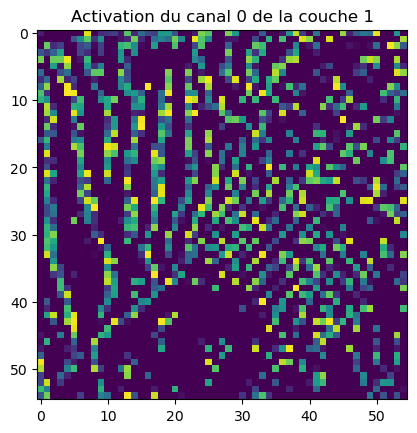

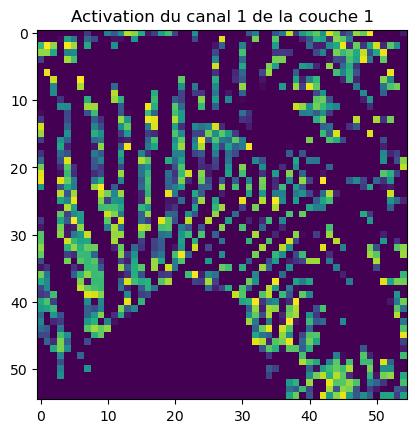

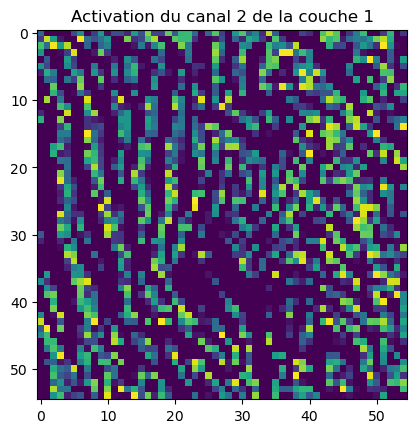

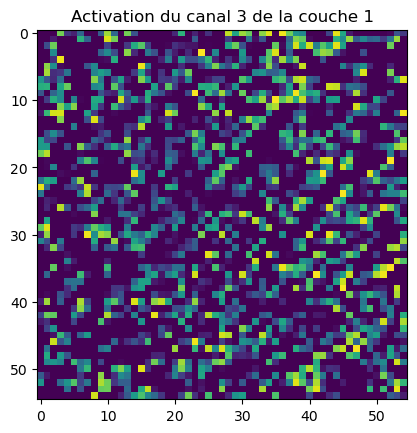

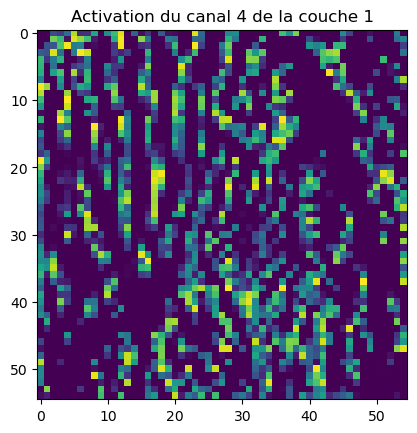

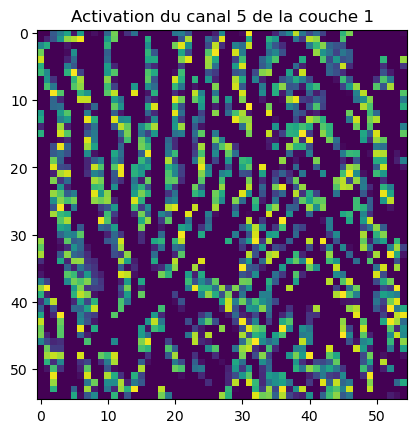

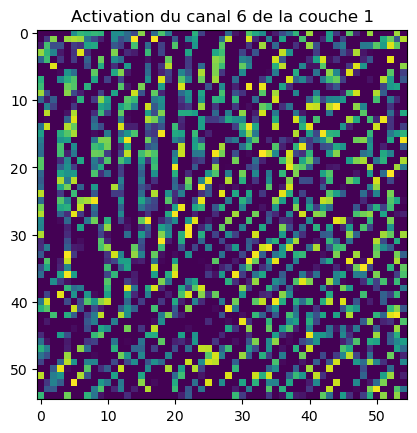

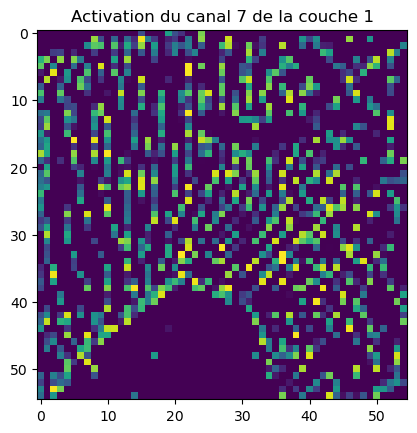

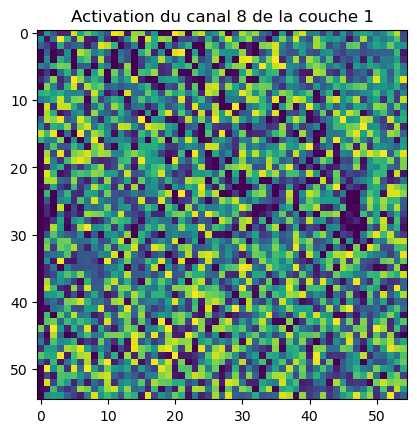

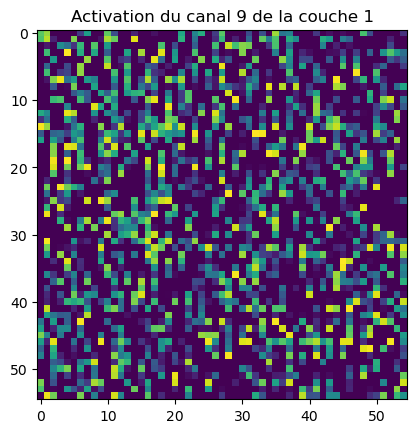

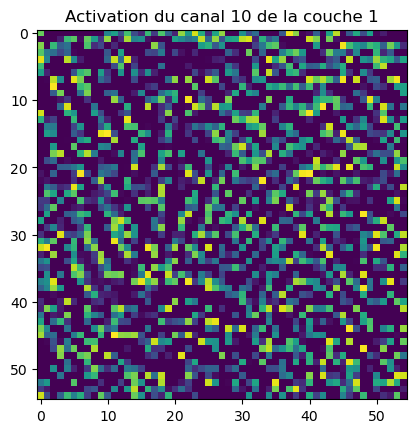

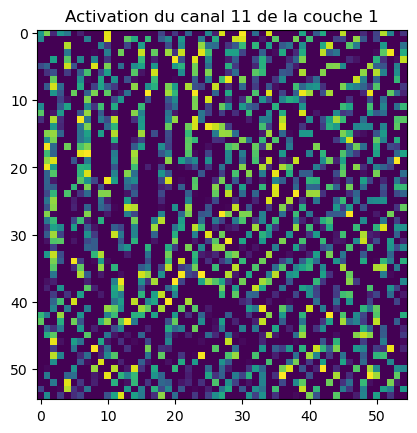

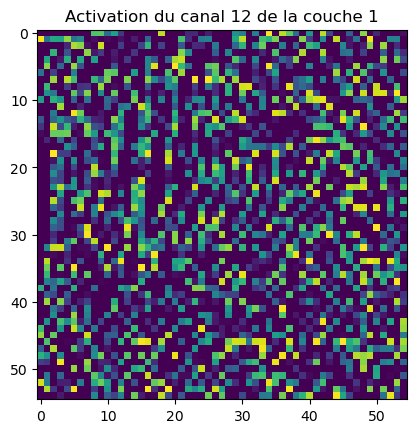

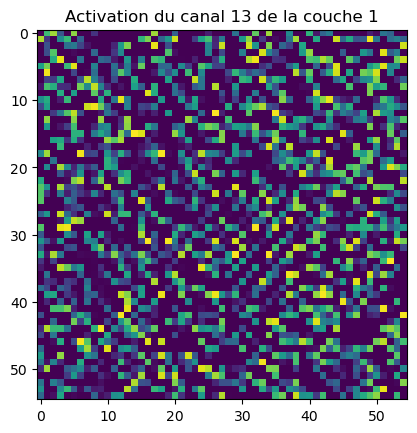

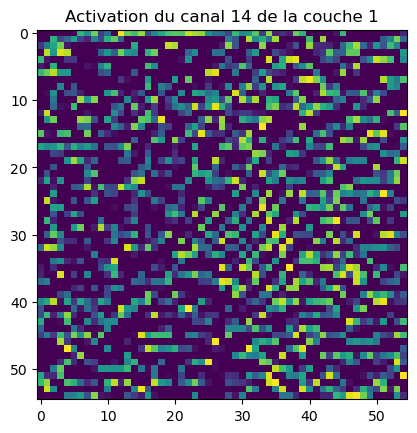

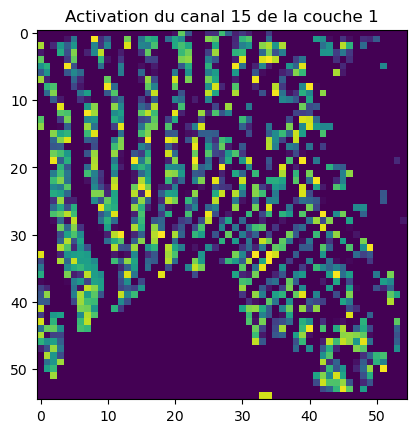

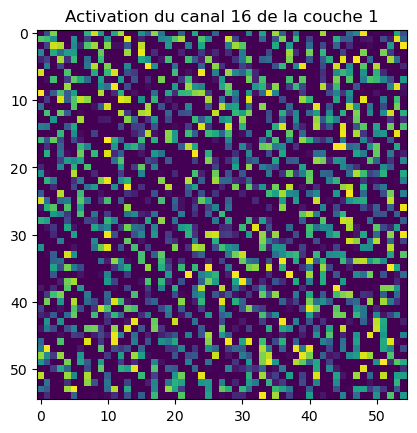

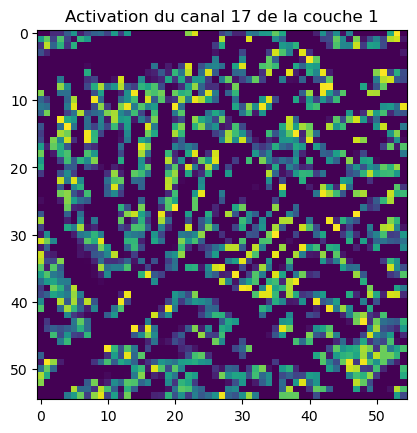

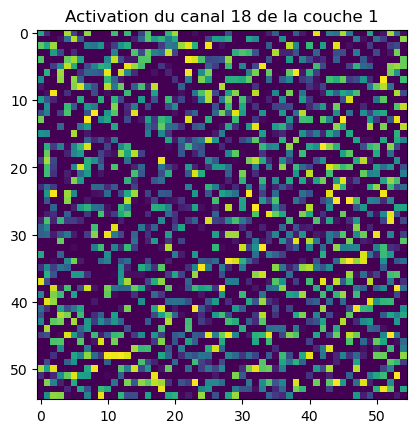

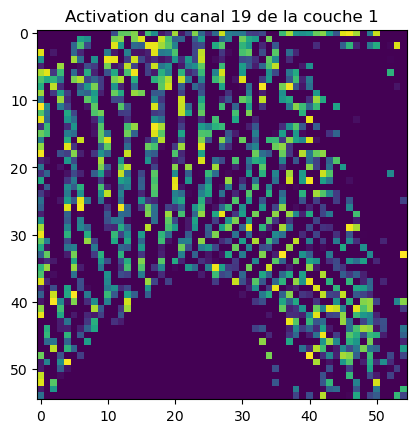

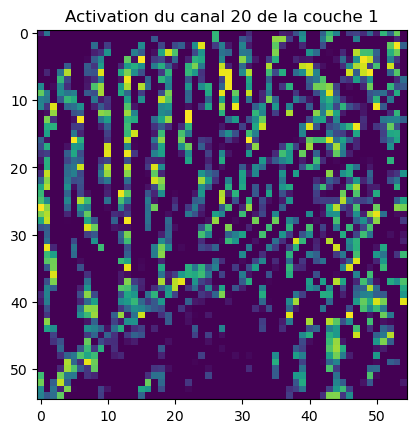

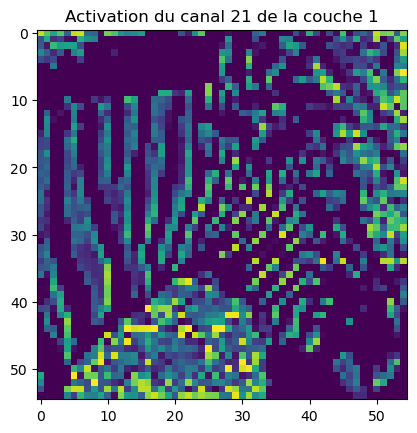

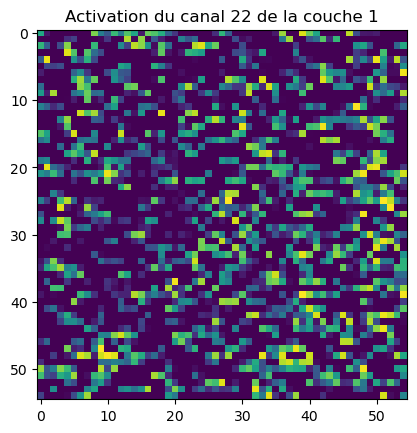

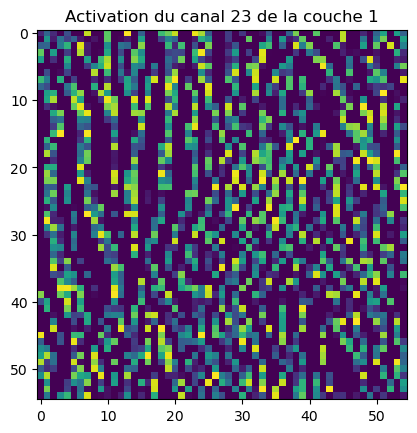

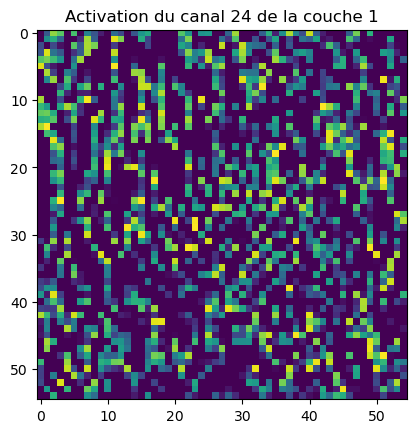

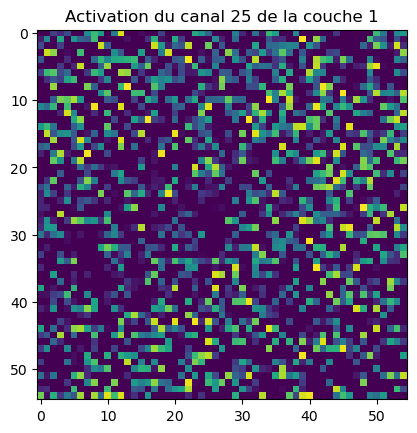

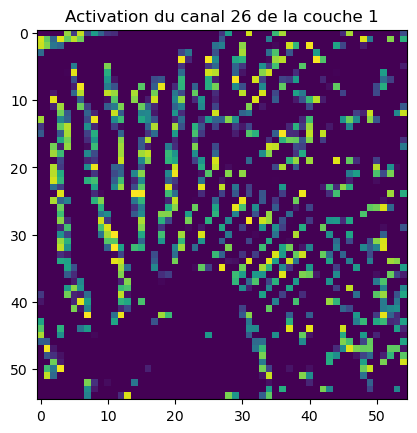

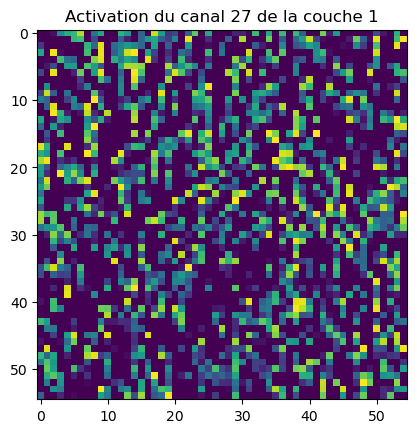

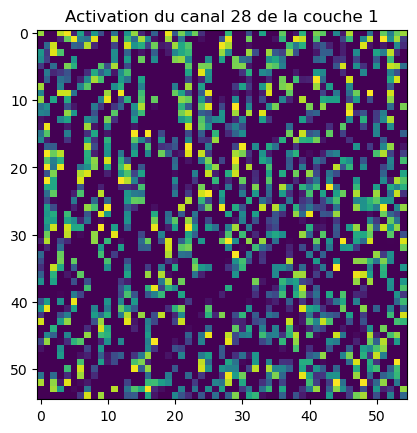

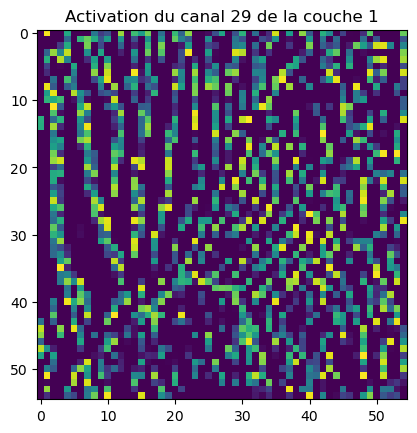

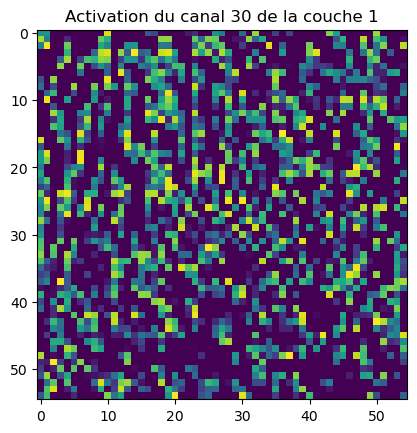

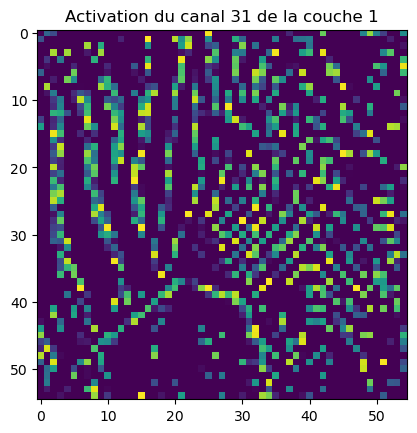

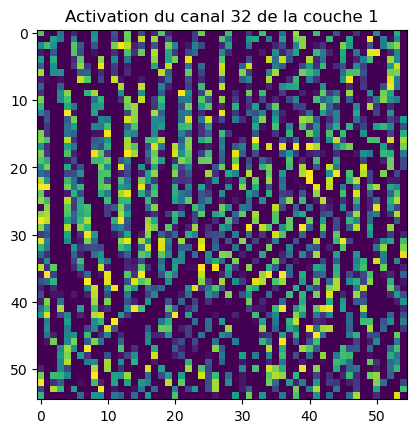

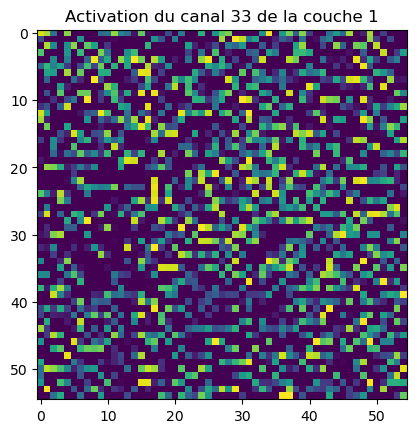

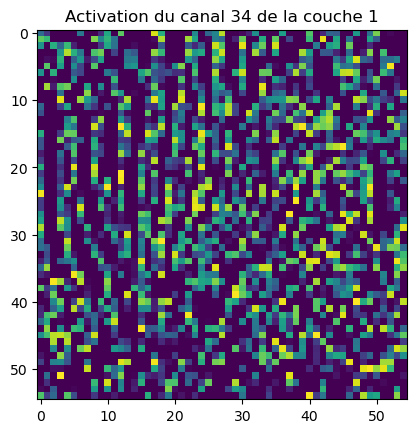

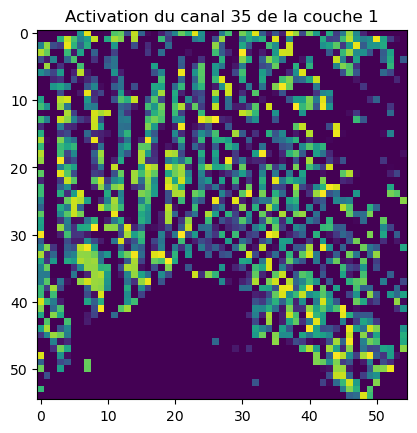

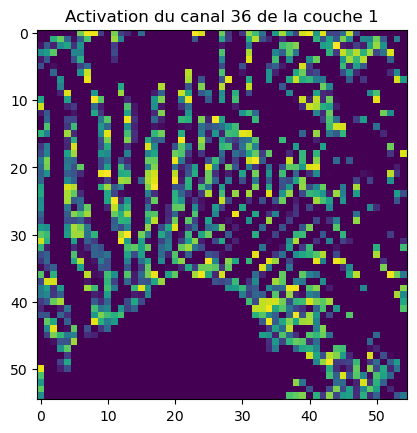

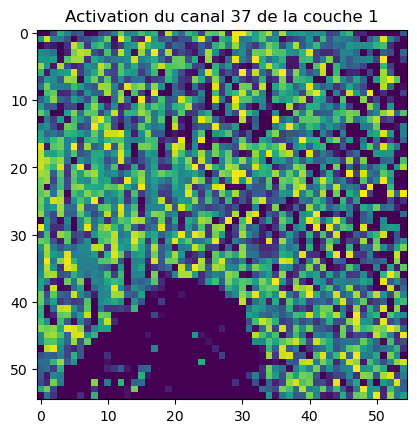

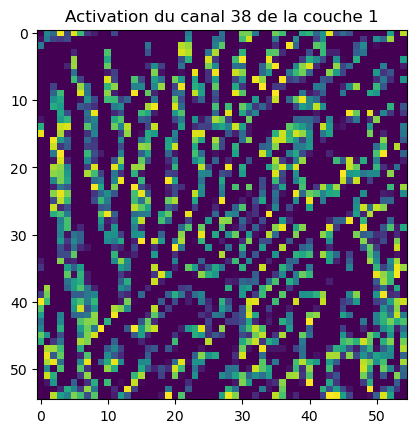

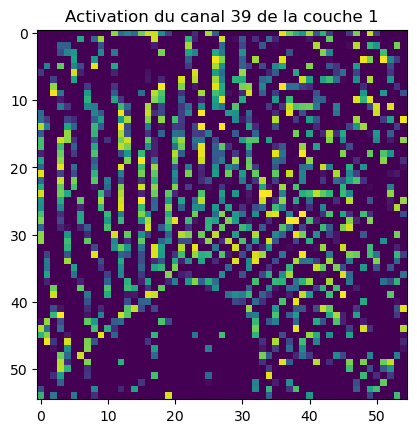

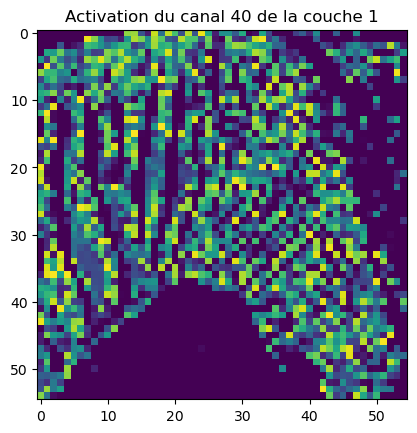

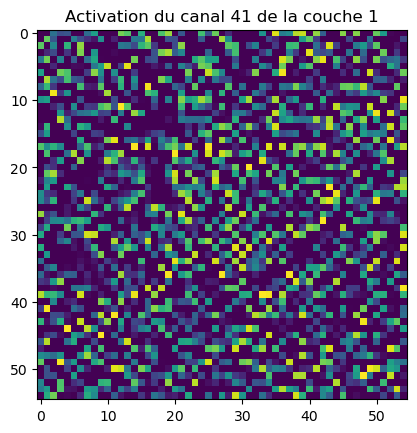

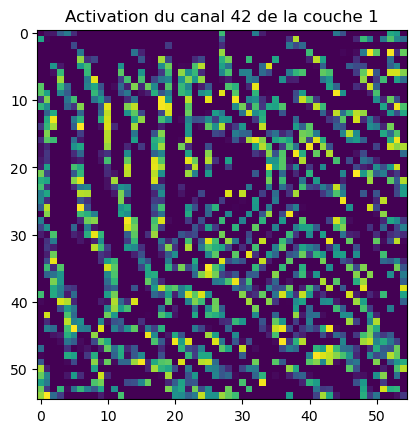

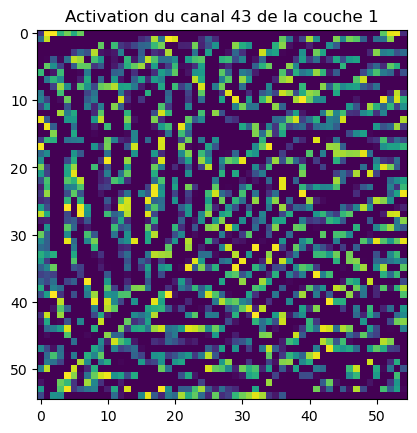

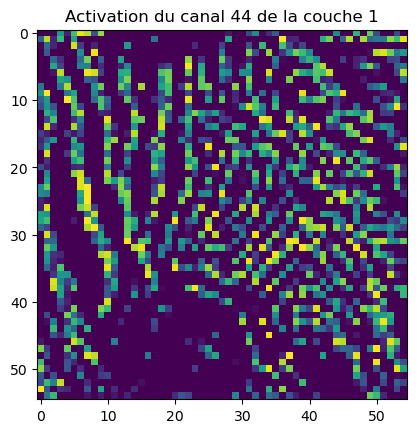

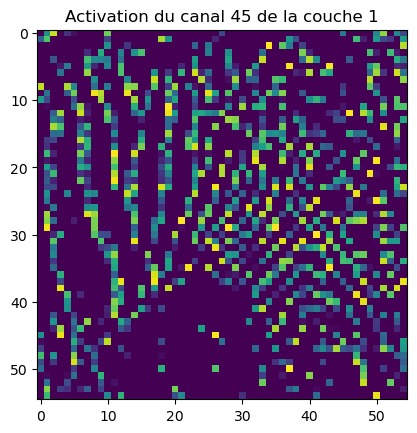

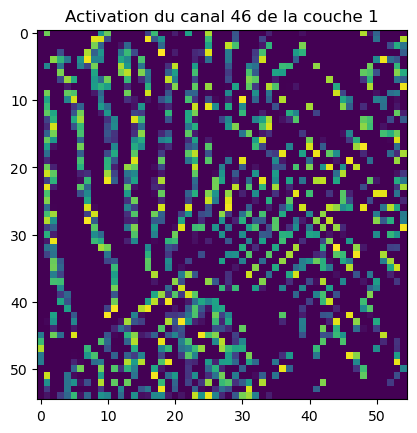

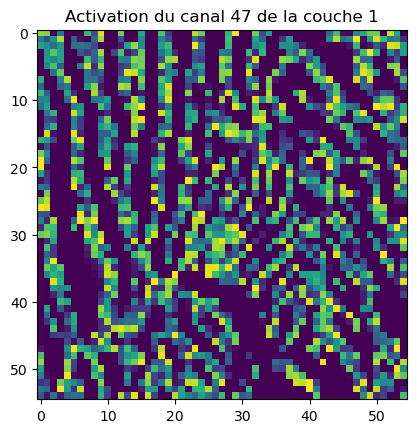

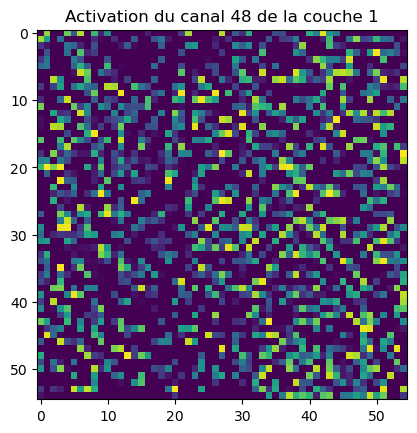

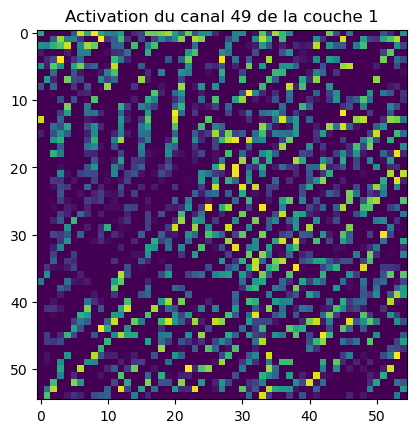

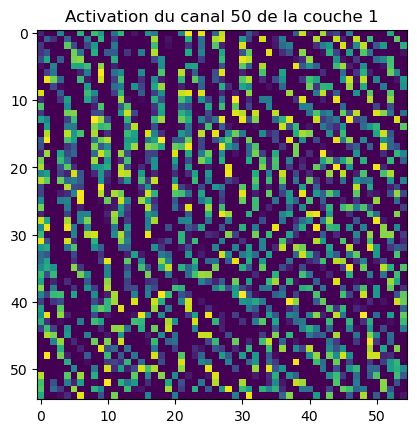

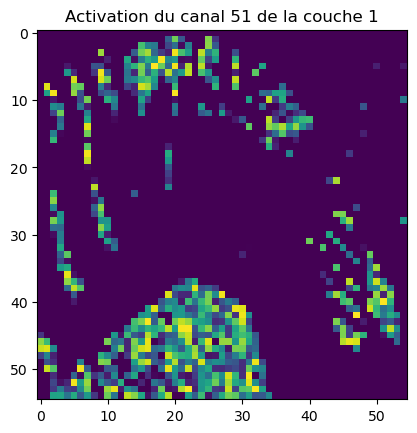

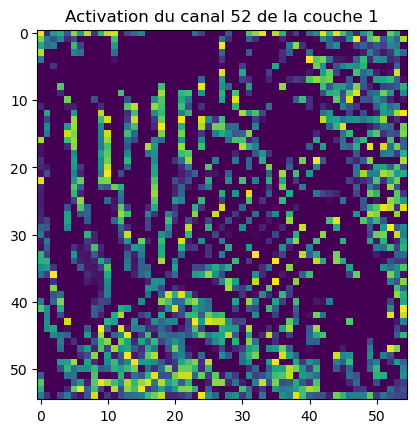

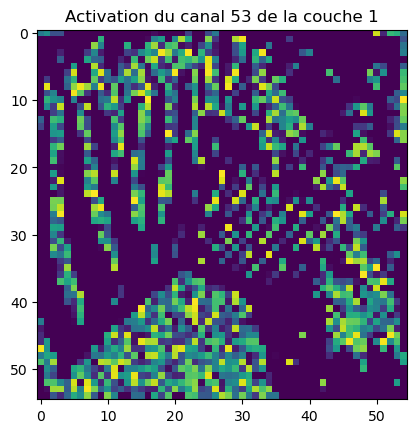

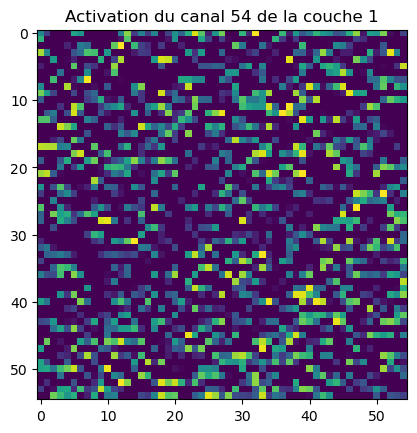

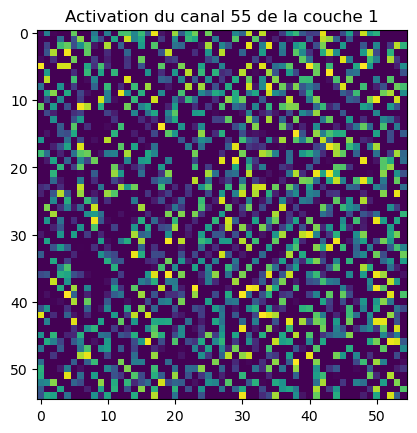

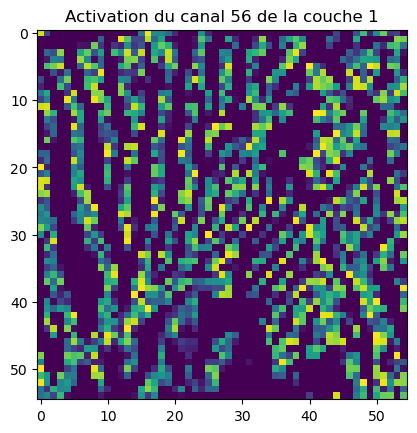

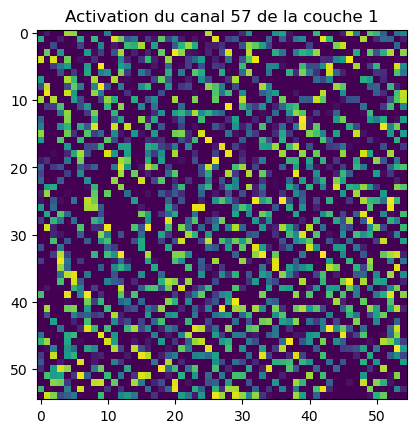

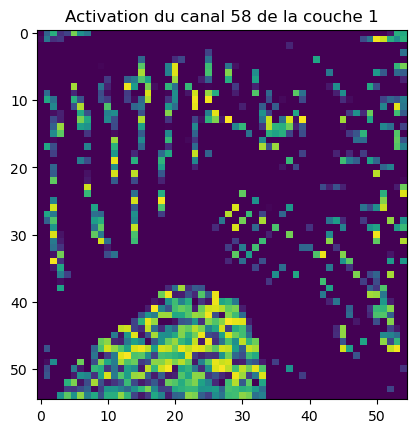

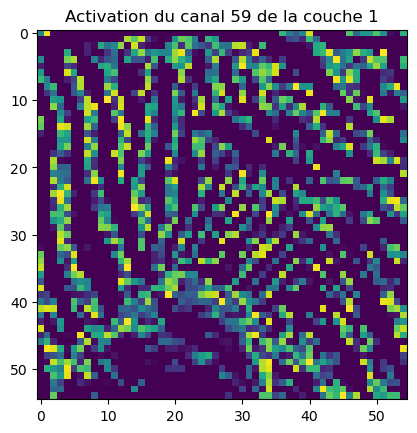

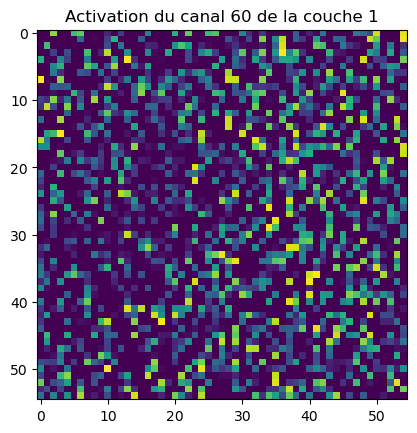

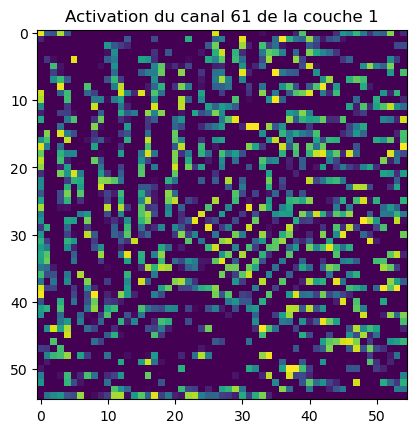

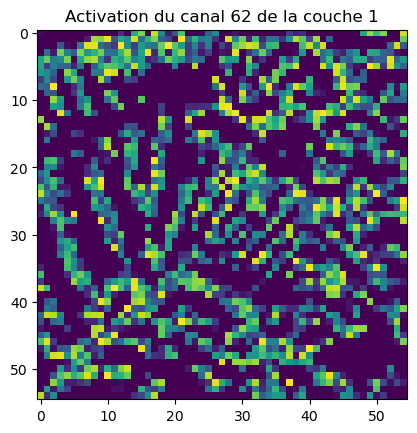

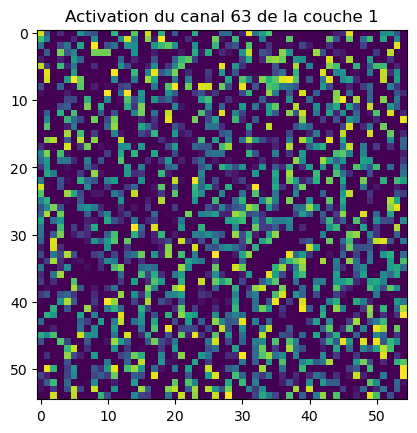

In [32]:
layer_index = 1
output, previous_outputs = features_handler.get_feature_layer_output(input_batch, layer_index)
print(output.size())
transform = T.ToPILImage()
for i, c in enumerate(output.squeeze()):
    plt.title(f"Activation du canal {i} de la couche {layer_index}")
    plt.imshow(F.to_pil_image(c), cmap="viridis")
    plt.show()

#### `.get_features_output()`

In [33]:
output, outputs = features_handler.get_features_output(input_batch)
print("output", output)
print("outputs", outputs)

output tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00, 9.7953e-01, 9.7953e-01,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 9.7953e-01, 9.7953e-01,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00]],

         [[3.5783e-01, 3.5783e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000

In [34]:
output, outputs = features_handler.get_features_output(input_batch, keep_previous=True)
print("output", output)
print("outputs", outputs)

output tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00, 9.7953e-01, 9.7953e-01,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 9.7953e-01, 9.7953e-01,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00]],

         [[3.5783e-01, 3.5783e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000

#### `.get_conv_output()`

In [35]:
output, outputs = features_handler.get_conv_output(input_batch, 2)
print("output", output)
print("outputs", outputs)

output tensor([[[[  5.6062,  -4.2957,  -1.4938,  ...,  11.9222,  13.6253,   5.0936],
          [  4.0858,  -7.0968,  -4.0411,  ...,  -9.2036,  -0.6781,   9.6227],
          [ -6.9796,  -3.9405,  -3.8421,  ...,  -9.9803,  -9.9490,   7.8758],
          ...,
          [-12.6752, -24.8918, -20.4339,  ..., -12.6593,  10.6731,   4.0805],
          [ 11.9300, -11.6185, -14.9599,  ...,  -8.0904,  -0.1339,   2.5755],
          [  2.6895,  -8.8878,  -2.3908,  ...,  -5.0741,   6.4262,   9.2766]],

         [[  4.4390,  -0.8125,  -1.9815,  ..., -13.6621,  -6.0365,  -8.5542],
          [ 19.2900,   4.3896,   8.4532,  ..., -16.2139,  -5.2934,  -5.9221],
          [ 32.2588,  22.4127,  20.9577,  ..., -10.5001, -10.0079,   3.3673],
          ...,
          [  1.0639,  -7.2232, -17.0762,  ...,  -3.8861,  -7.1818, -16.3196],
          [ -0.5348, -22.4221, -14.5605,  ...,   3.4988,  -6.9171,  -8.6300],
          [  0.1488, -12.8521,  -8.5381,  ...,   6.2916,  -8.9984,  -7.3764]],

         [[ -5.1729, -1

In [36]:
output, outputs = features_handler.get_conv_output(input_batch, 4, keep_previous=True)
print("output", output)
print("outputs", outputs)

output tensor([[[[-8.5693e+00, -4.3192e+00,  4.8029e+00,  ..., -1.3502e+01,
           -7.5603e+00, -4.1893e-01],
          [-2.0564e+01, -1.8735e+01, -1.4601e+01,  ..., -2.2232e+01,
           -1.1253e+01, -2.1794e+00],
          [-1.6139e+01, -1.3513e+01, -1.3313e+01,  ..., -3.3475e+01,
           -1.2548e+01,  2.4241e+00],
          ...,
          [-1.3727e+01, -1.0767e+01, -7.5090e+00,  ..., -1.3071e+01,
           -9.0567e+00, -9.9238e+00],
          [-9.8506e+00, -1.2301e+01, -3.9590e+00,  ..., -1.1915e+01,
           -1.2523e+01, -8.9028e+00],
          [-3.4174e+00, -4.9458e+00,  8.4678e+00,  ..., -8.3573e+00,
           -1.0153e+01, -6.6579e+00]],

         [[ 3.4841e+00,  1.0487e+01,  6.3085e+00,  ..., -7.8771e+00,
           -9.8441e+00, -5.7070e+00],
          [-1.9654e+00, -3.6210e-01, -6.8542e+00,  ..., -2.0722e+01,
           -2.6436e+01, -1.7051e+01],
          [ 1.6646e+00, -1.7171e+00, -5.1932e+00,  ..., -1.9536e+01,
           -2.8353e+01, -2.1480e+01],
          ...

#### `.get_feature_layer_summary()` \[1/2]

In [37]:
try:
    assert features_handler.get_feature_layer_summary(1) == None, "Should be None and print 'Process summary first calling ...'"
except IndexError as err:
    print("Error: {}".format(err))
    

Error: Process summary first calling '.summary()'


#### `.summary`

In [38]:
features_handler.summary()

input size: torch.Size([1, 3, 224, 224])
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 256, 6, 6]            --
├─Conv2d: 1-1                            [1, 64, 55, 55]           23,296
├─ReLU: 1-2                              [1, 64, 55, 55]           --
├─MaxPool2d: 1-3                         [1, 64, 27, 27]           --
├─Conv2d: 1-4                            [1, 192, 27, 27]          307,392
├─ReLU: 1-5                              [1, 192, 27, 27]          --
├─MaxPool2d: 1-6                         [1, 192, 13, 13]          --
├─Conv2d: 1-7                            [1, 384, 13, 13]          663,936
├─ReLU: 1-8                              [1, 384, 13, 13]          --
├─Conv2d: 1-9                            [1, 256, 13, 13]          884,992
├─ReLU: 1-10                             [1, 256, 13, 13]          --
├─Conv2d: 1-11                           [1, 256, 13, 13]          590,080
├─ReLU: 1-12        

#### `.show_feature_list()`

In [39]:
features_handler.show_feature_list()

idx:   0 - Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
idx:   1 - ReLU(inplace=True)
idx:   2 - MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
idx:   3 - Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
idx:   4 - ReLU(inplace=True)
idx:   5 - MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
idx:   6 - Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
idx:   7 - ReLU(inplace=True)
idx:   8 - Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
idx:   9 - ReLU(inplace=True)
idx:  10 - Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
idx:  11 - ReLU(inplace=True)
idx:  12 - MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)


#### `.get_feature_layer_summary()` \[2/2]

In [40]:
r = features_handler.get_feature_layer_summary(1)
assert r == [1, 64, 55, 55], "Issue with get_feature_layer_summary"
r

[1, 64, 55, 55]

## Manipulations

In [41]:
c_model =  cnn_models["alexet"] # current model
imagenet_preprocess = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=imagenet_mean, std=imagenet_std),
])
input_tensor = imagenet_preprocess(input_image)
print(input_tensor.min(), input_tensor.max())

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [ ]:
input_batch = input_tensor.unsqueeze(0)
c = c_model(input_batch)
c.squeeze()

In [ ]:
classif = torch.argmax(c.squeeze())
classif = classif.item()

print(classif, "-", labels[str(classif)])

#### `standard_scale()`

In [ ]:
def standard_scale(matrice: np.array, max: int) -> np.array:
    matrice -= matrice.mean()
    matrice /= matrice.std()
    matrice *= max // 4
    matrice += max // 2
    return matrice

#### `tensor2d_to_images()`

In [ ]:
def tensor2d_to_images(t: torch.Tensor) -> np.array:
    images = t.detach().numpy()

    for i in range(images.shape[0]):
        image = images[i, :, :]
        # Standardisation(Centrage/Réduction) si besoin et projection dans [0, 255]
        image = standard_scale(image, 256)
        # Contrainte sur les valeurs de couleurs et conversion de type
        image = np.clip(image, 0, 255).astype("uint8")
        images[i, :, :] = image
    return images

#### `display_grid_1c()`

In [ ]:
def display_grid_1c(
        pictures: np.array,
        images_per_row: int=16,
        title: str="",
        cmap: str="viridis",
        figsize: Tuple[int,int]=None
        ) -> None:
    """ 
    - Argument(s)
        images_per_row : int
            Nombre d'images par ligne
    """
    
    ##DEBUG
    #print(pictures.size())

    # Nombre de canaux de la carte d'activation
    # And taille spatiale d'une carte présumée carrée
    n_features, size, _ = pictures.shape
    # Nombre de lignes nécessaires
    n_cols = n_features // images_per_row
    # Taille de la grille avec séparation de 1 pixel en H/Y et W/X
    margin_H, margin_W = 1, 1
    
    ##DEBUG
    #print(n_features, size, n_cols)
    #print(((size + margin_W) * n_cols - margin_W,
    #                        images_per_row * (size + margin_H) - margin_H))
    
    display_grid = np.zeros(((size + margin_W) * n_cols - margin_W,
                            images_per_row * (size + margin_H) - margin_H))
    # Pour chaque colonne
    for col in range(n_cols):
        # Pour chaque ligne
        for row in range(images_per_row):
            # Index du canal
            channel_index = col * images_per_row + row
            # Matrice de pixels de ce canal
            channel_image = pictures[channel_index, :, :]
            # Application de l'image dans la grille
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
        
    # Mise à l'échelle pour l'affichage
    if not figsize:
        scale = 1. / size
        figsize = (scale * display_grid.shape[1], scale * display_grid.shape[0])
    plt.figure(figsize=figsize);
    
    # Affichage
    if title:
        plt.title(title)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap=cmap)

### Affichage des cartes d'activation pour les couches de conv du réseau (basses vers hautes)

In [ ]:
for conv_pos in range(1, features_handler.get_conv_layers_count() + 1):
    output, _ = features_handler.get_conv_output(input_batch, conv_pos, keep_previous=False)
    suffix = "ère" if conv_pos == 1 else "ème"
    pictures = tensor2d_to_images(output.squeeze())
    display_grid_1c(pictures, cmap="grey", title=f"Cartes d'activation de la {conv_pos}{suffix} couche")

## Deconvnet

### `get_receptive_field()`, `get_receptive_field_conv2d()`, `get_receptive_field_pool2d()`

In [ ]:
def get_receptive_field(pos, k, s, p):
    _to_tuple = lambda v: (v, v)
    if type(k) == int:
        k = _to_tuple(k)
    if type(s) == int:
        s = _to_tuple(s)
    if type(p) == int:
        p = _to_tuple(p)
    column = -p[1] + pos[1] * s[1]
    row = -p[0] + pos[0] * s[0]
    return (row, column), (row+k[1], column+k[0])

def get_receptive_field_conv2d(pos, k, s, p):
    return get_receptive_field(pos, k, s, p)

def get_receptive_field_pool2d(pos, k, s, p): 
    return get_receptive_field(pos, k, s, p)

### Classe `DeconvnetProcessor`

In [ ]:
class DeconvnetProcessor(CNNFeaturesHandler):
    def __init__(self, cnn_model_features: list[nn.Module]|nn.Sequential):
        """ New instance initialization """
        super().__init__(cnn_model_features)
        self.reset()


    def update_model(self, new_status=True) -> None:
        """
            Set MaxPooling layer's return_indices setting to True in order to get indices necessary for deconv backward
        """
        for layer in self.model_features:
            if isinstance(layer, nn.MaxPool2d):
                layer.return_indices=new_status


    def reset(self) -> None:
        self.maxpool_indices = []
        self.forward_outputs_ = None
        self.strongest_activation_ = None # will be (float, [int, int])


    def get_strongest_activation_feature_map(self, feature_map: torch.Tensor) -> torch.Tensor:
        """ 
        """
        o = torch.zeros_like(feature_map)
        idx_max = torch.argmax(feature_map).item()
        row_max = idx_max // feature_map.size(0)
        column_max = idx_max % feature_map.size(1)
        max = feature_map.max()
        self.strongest_activation_ = (max, (row_max, column_max))
        o[row_max, column_max] = self.strongest_activation_[0]
        return o
        

    def get_feature_maps_for_backward(self, feature_maps: torch.tensor, kernel_idx: int=0) -> torch.Tensor:
        """ Returns the zeroed output tensor but the channel_idx'th feature map """
        t = torch.zeros_like(feature_maps)
        strongest_activation_feature_map = self.get_strongest_activation_feature_map(feature_maps[0, kernel_idx])
        t[0, kernel_idx] = strongest_activation_feature_map
        return t


    def forward_keeping_indices(self, x: torch.Tensor, to_layer_idx: int=-1, verbose=False) -> torch.Tensor:
        """ 
        - Argument(s) :
            x : torch.Tensor
                size = (batch, channels, H, W)
            to_layer_idx : int
        """
        to_layer_idx = self.get_normalized_idx(to_layer_idx)
        self.assert_correct_layer_idx(to_layer_idx)

        self.update_model(new_status=True) # Must be done before .val()
        self.model_features.eval()
        with torch.no_grad():
            self.maxpool_indices.clear()
            for idx, layer in enumerate(self.model_features):
                print(idx, layer)

                if isinstance(layer, nn.MaxPool2d):
                    x, indices = layer(x)
                    self.maxpool_indices.append(indices)
                else:
                    x = layer(x)
                # stop at the to_layer_idx'th layer
                if idx == to_layer_idx:
                    break;
        self.model_features.train()
        self.update_model(new_status=False)
        return x


    def backward(self, y: torch.Tensor, from_layer_idx: int=-1, flip_kernel=False, verbose=False):
        """
        Because the deconvnet process is a symetric of the feature part of the CNN model
        """
        from_layer_idx = self.get_normalized_idx(from_layer_idx)
        self.assert_correct_layer_idx(from_layer_idx)

        idx_maxpool_indices = -1
        for i, layer in enumerate(reversed(self.model_features), start=1):
            idx = len(self.model_features) - i

            # only backward from the from_layer_idx'th layer
            if from_layer_idx < idx:
                continue

            if verbose:
                print(f"idx :{idx}", f"y : {y.size()}", layer)

            if isinstance(layer, nn.MaxPool2d):
                indices = self.maxpool_indices[idx_maxpool_indices]
                y = nn.functional.max_unpool2d(
                    y,
                    indices=indices,
                    kernel_size=layer.kernel_size,
                    stride=layer.stride,
                    padding=layer.padding
                )
                idx_maxpool_indices -= 1
            
            elif isinstance(layer, nn.ReLU):
                y = nn.functional.relu(y)
            
            elif isinstance(layer, nn.Conv2d):
                weights = self.model_features[idx].weight
                # No need to transpose weights kernel tensor
                #weights = torch.transpose(weights, 0, 1)
                if flip_kernel:
                    torch.flip(weights, [2, 3])

                if verbose:
                    print("weights: ", weights.size())

                y = nn.functional.conv_transpose2d(
                    y,
                    weight=weights,
                    #bias=layer.bias,
                    stride=layer.stride,
                    padding=layer.padding,
                    output_padding=1 if layer.stride[0] > 1 else 0, # Because stride > 1
                    dilation=layer.dilation
                )
        
        return y


    def forward_backward(self, 
                         x: torch.Tensor, 
                         to_layer_idx: int=-1, 
                         kernel_idx: int=0, 
                         flip_kernel=False, 
                         reset_forward=True,
                         verbose=False) -> torch.Tensor:
        """ """
        if reset_forward or self.forward_outputs_ == None:
            self.reset()
            self.forward_outputs_ = self.forward_keeping_indices(x, to_layer_idx, verbose=verbose)

        y = self.get_feature_maps_for_backward(self.forward_outputs_, kernel_idx)
        y = self.backward(y, to_layer_idx, flip_kernel=flip_kernel, verbose=verbose)
        
        return y
    

    def get_receptive_field_of_activation(self, idx_layer: int, activation_pos: Tuple[int, int]):
        """ """
        idx_layer = self.get_normalized_idx(idx_layer)
        self.assert_correct_layer_idx(idx_layer)
        
        tlc, brc = activation_pos, activation_pos
        for module in reversed(self.model_features[:idx_layer+1]):
            #print(module)
            if isinstance(module, nn.Conv2d):
                tlc, _ = get_receptive_field_conv2d(tlc, module.kernel_size, module.stride, module.padding)
                _, brc = get_receptive_field_conv2d(brc, module.kernel_size, module.stride, module.padding)
            elif isinstance(module, nn.MaxPool2d):
                tlc, _ = get_receptive_field_pool2d(tlc, module.kernel_size, module.stride, module.padding)
                _, brc = get_receptive_field_pool2d(brc, module.kernel_size, module.stride, module.padding)
            #print(tlc, brc)
        return (tlc, brc)

#### Tests de `DeconvnetProcessor`

##### `.__init__()`

In [ ]:
model = models.alexnet(weights='IMAGENET1K_V1')
model_features = model.features
deconv = DeconvnetProcessor(model_features)
deconv.show_feature_list()

In [ ]:
# !! Warning !! maxpooling return_indices setting must be False
input_batch_size = torch.Size([1, 3, 224, 224])
s = summary(deconv.model_features, input_size=input_batch_size)
s

In [ ]:
s.summary_list[1].output_size

In [ ]:
deconv.summary()

##### `.get_strongest_activation_feature_map()`

In [ ]:
to_layer_idx = 5
feature_maps, _ = features_handler.get_feature_layer_output(input_batch, to_layer_idx)
feature_maps = feature_maps.squeeze()
kernel_idx = feature_maps.size(0) // 2
feature_map = feature_maps[kernel_idx]
print(kernel_idx, feature_map.size())
strongest_activation_feature_map = deconv.get_strongest_activation_feature_map(feature_map)
print(strongest_activation_feature_map.max(), feature_map.max())
assert strongest_activation_feature_map.max() == feature_map.max(), "Issue with get_strongest_activation_feature_map"
assert deconv.strongest_activation_[0] == feature_map.max(), "Issue with get_strongest_activation_feature_map and strongest_activation_"

##### `.get_feature_maps_for_backward()`

In [ ]:
t = torch.rand(1, 3, 5, 5)
t = torch.nn.functional.normalize(t)
for i in range(3):
    t[0, i, i, i] = i + 2

t_t = torch.zeros_like(t)
t_t[0, 0, 0, 0] = 2
fmfb = deconv.get_feature_maps_for_backward(t, 0)
assert torch.equal(fmfb.type(torch.float16), t_t.type(torch.float16)), "Issue with get_strongest_activation_feature_map"

t_t = torch.zeros_like(t)
t_t[0, 1, 1, 1] = 3
assert torch.equal(deconv.get_feature_maps_for_backward(t, 1), t_t), "Issue with get_strongest_activation_feature_map"

t_t = torch.zeros_like(t)
t_t[0, 2, 2, 2] = 4
assert torch.equal(deconv.get_feature_maps_for_backward(t, 2), t_t), "Issue with get_strongest_activation_feature_map"

##### `.update_model()`

In [ ]:
input = torch.randn(20, 16, 50, 32)

deconv.update_model(new_status=True)
maxpool_layer = deconv.get_feature_layer(2)
#print(maxpool_layer)
output = maxpool_layer(input)
assert len(output)==2, "Issue with update_model (True)"

deconv.update_model(new_status=False)
maxpool_layer = deconv.get_feature_layer(2)
output = maxpool_layer(input)
#print(output)
assert isinstance(output, torch.Tensor), "Issue with update_model (False)"

##### `.forward_keeping_indices()`

In [ ]:
to_layer_idx = 6
forward_output = deconv.forward_keeping_indices(input_batch, to_layer_idx=to_layer_idx)
assert forward_output.size() == torch.Size([1, 384, 13, 13]), "Issue with forward_keeping_indices"

In [ ]:
to_layer_idx = -1
forward_output = deconv.forward_keeping_indices(input_batch, to_layer_idx=to_layer_idx)
assert forward_output.size() == torch.Size([1, 256, 6, 6]), "Issue with forward_keeping_indices"

##### `.backward()`

In [ ]:
to_layer_idx = 2
forward_output = deconv.forward_keeping_indices(input_batch, to_layer_idx=to_layer_idx)
print(forward_output.size())
assert forward_output.size() == torch.Size([1, 64, 27, 27]), "Issue with forward_keeping_indices"

In [ ]:
channel_idx = forward_output.size(1) // 2
print(channel_idx)
input_backward = deconv.get_feature_maps_for_backward(forward_output, channel_idx)
print(input_backward.size())
assert input_backward.size() == torch.Size([1, 64, 27, 27]), "Issue with forward_keeping_indices"
assert input_backward[0, 0, :, :].sum().item() == 0, "Issue with forward_keeping_indices"
assert input_backward[0, -1, :, :].sum().item() == 0, "Issue with forward_keeping_indices"

In [ ]:
from_layer_idx = to_layer_idx
backward_output = deconv.backward(input_backward, from_layer_idx)
backward_output.size()

##### `.forward_backward()`

In [ ]:
to_layer_idx = 3 # After the first Conv2D-ReLU-MaxPool block
number_channels = deconv.get_feature_layer_summary(to_layer_idx)[1]
output_backward = deconv.forward_backward(input_batch, to_layer_idx, channel_idx)
print(output_backward.size(1))
assert output_backward.size(1) == 3, "Issue with forward_backward"

##### `.get_receptive_field_of_activation()`

In [ ]:
deconv.get_receptive_field_of_activation(idx_layer=3, activation_pos=(1, 1))

#### `shift_to_RGB_range()`

In [ ]:
def shift_to_RGB_range(t: np.array, range256: bool=False, min: int|float=None, max: int|float=None) ->  torch.Tensor:
    """ 
    Args:
        t : torch.Tensor
            (n, c, H, W) tensor of images
        range256 : bool
            range [0, 255] if True, range [0, 1.0] else
    """
    shift_min = 0
    shift_max = 256 if range256 else 1.
    t_min = t.min() if min == None else min
    t_max = t.max() if max == None else max

    shifted = (shift_max - shift_min) * (t - t_min) / (t_max - t_min) + shift_min
    shifted = shifted.astype(np.uint8) if range256 else shifted.astype(np.float32)

    return shifted

#### `tensor3d_to_image()`

In [ ]:
def tensor3d_to_image(t: torch.Tensor) -> np.array:
    npimg = t.detach().numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    #npimg = ((npimg * imagenet_std) + imagenet_mean)

    return npimg

#### `show_tensor3d_as_image()`

In [ ]:
def show_tensor3d_as_image(t: torch.Tensor, axis: bool=False, title: str="", shift=True):
    npimg = tensor3d_to_image(t)
    if shift:
        npimg = shift_to_RGB_range(npimg)

    if not axis:
        plt.axis("off")
    if title:
        plt.title(title)
    plt.imshow(npimg, interpolation="nearest");
    plt.show()

In [ ]:
t = backward_output.squeeze()
print(t.min().item(), t.max().item())

In [ ]:
show_tensor3d_as_image(t.squeeze())

In [ ]:
show_tensor3d_as_image(input_batch.squeeze())

## Noyaux de la première couche

In [ ]:
deconv.get_conv_layer(1)

In [ ]:
deconv.get_conv_def(1)

In [ ]:
deconv.get_feature_layer_summary(deconv.get_conv_index(1))

In [ ]:
weights = deconv.get_conv_layer(1).weight
weights.size()

In [ ]:
weights[0]

In [ ]:
weights = weights.detach().numpy()
w = weights[0]
print(w.min(), w.max(), w.mean(), w.std())

In [ ]:
weights_r = shift_to_RGB_range(weights)
weights_r

In [ ]:
weights_r.size()

### `display_grid_3c()`

In [ ]:
def display_grid_3c(
        pictures: np.array,
        images_per_row: int=16,
        title: str="",
        cmap: str="viridis",
        figsize: Tuple[int,int]=None
        ) -> None:
    """ 
    - Argument(s)
        images_per_row : int
            Nombre d'images par ligne
    """
    
    ##DEBUG
    #print(pictures.size())

    # Nombre de canaux de la carte d'activation
    # And taille spatiale d'une carte présumée carrée
    n, size, _, _ = pictures.shape
    # Nombre de lignes nécessaires
    n_cols = math.ceil(n / images_per_row)

    # Taille de la grille avec séparation de 1 pixel en H/Y et W/X
    margin_H, margin_W = 1, 1
    
    ##DEBUG
    #print(n_features, size, n_cols)
    #print(((size + margin_W) * n_cols - margin_W,
    #                        images_per_row * (size + margin_H) - margin_H))
    
    display_grid = np.zeros(((size + margin_W) * n_cols - margin_W,
                            images_per_row * (size + margin_H) - margin_H,
                            3))
    # Pour chaque colonne
    for col in range(n_cols):
        # Pour chaque ligne
        for row in range(images_per_row):
            # Index du canal
            channel_index = col * images_per_row + row
            if channel_index >= len(pictures):
                break
            # Matrice de pixels de ce canal
            channel_image = pictures[channel_index, :, :, :]
            # Application de l'image dans la grille
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row, :] = channel_image
        
    # Mise à l'échelle pour l'affichage
    if not figsize:
        scale = 1. / size
        figsize = (scale * display_grid.shape[1], scale * display_grid.shape[0])
    plt.figure(figsize=figsize);
    
    # Affichage
    if title:
        plt.title(title)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap=cmap)

In [ ]:
display_grid_3c(
    torch.permute(weights_r.detach(), (0, 2, 3, 1)).numpy(),
    images_per_row=10,
    title="Poids de noyaux de la première couche"
    )

In [ ]:
image_array = shift_to_RGB_range(weights_r[])

R = image_array[:,:,0]
G = image_array[:,:,1]
B = image_array[:,:,2]

bin_edges = np.linspace(0, 255, 256)
hist_R, _ = np.histogram(R, bins=bin_edges, density=True)
hist_G, _ = np.histogram(G, bins=bin_edges, density=True)
hist_B, _ = np.histogram(B, bins=bin_edges, density=True)

# Créer une figure pour les courbes
plt.figure(figsize=(10, 6))

# Afficher les courbes
plt.step(bin_edges[:-1], hist_R, where='mid', color='red', label='Rouge')
plt.step(bin_edges[:-1], hist_G, where='mid', color='green', label='Vert')
plt.step(bin_edges[:-1], hist_B, where='mid', color='blue', label='Bleu')

# Ajouter des légendes et des titres
plt.title('Distribution des canaux RGB')
plt.xlabel('Intensité de couleur')
plt.ylabel('Densité')
plt.legend()

# Afficher le graphique
plt.show()

## Visualisation des caractérisques de la première couche

In [ ]:
model = models.alexnet(weights='IMAGENET1K_V1')
model_features = model.features
deconv = DeconvnetProcessor(model_features)
deconv.summary(verbose=False)

In [ ]:
input_batch_size[2]

In [ ]:
idx_conv = deconv.get_conv_index(2)
to_layer_idx = idx_conv + 2
number_kernels = deconv.get_feature_layer_summary(to_layer_idx)[1]
outputs = []
print(f"to_layer_idx: {to_layer_idx} , number_kernels: {number_kernels}")

number_kernels = 1
for kernel_idx in range(number_kernels):
    output_backward = deconv.forward_backward(input_batch, to_layer_idx, kernel_idx, reset_forward=False, flip_kernel=False)
    output_backward_size = output_backward.size()
    #show_tensor3d_as_image(output_backward.squeeze())
    array = torch.clamp(output_backward.detach().squeeze(), min=0).numpy()
    print(f"[{kernel_idx}]", array.shape)
    print("\t", deconv.strongest_activation_)
    
    # Crop to get image patch corresponding of receptive field of max activation
    tlc, brc = deconv.get_receptive_field_of_activation(to_layer_idx, activation_pos=deconv.strongest_activation_[1])
    tlc = list(tlc)
    brc = list(brc)
    # The field must be in picture space
    if tlc[0] < 0:
        brc[0] -= tlc[0]
        tlc[0] = 0
    if tlc[1] < 0:
        brc[1] -= tlc[1]
        tlc[1] = 0
    if brc[0] >= output_backward_size[2]:
        tlc[0] -= brc[0] - (output_backward_size[2] - 1)
        brc[0] = output_backward_size[2] - 1
    if brc[1] >= output_backward_size[3]:
        tlc[1] -= brc[1] - (output_backward_size[3] - 1)
        brc[1] = output_backward_size[3] - 1

    print("\t", kernel_idx, array.min(), array.max(), array.mean(), tlc, brc, np.array(brc) - np.array(tlc))

    picture = shift_to_RGB_range(output_backward.detach()).squeeze()
    #picture = torch.clamp(output_backward.detach(), min=0).squeeze()
    #picture = shift_to_RGB_range(torch.clamp(output_backward.detach(), min=0).squeeze())

    picture = torch.permute(picture, (1, 2, 0)).numpy()
    print("\tshifted picture.shape", picture.shape, type(picture))

    cropped_picture = picture[tlc[0]:brc[0]+1, tlc[1]:brc[1]+1, :]
    #cropped_picture = picture
    print("\tcropped_picture.shape :", cropped_picture.shape)
    outputs.append(cropped_picture)

outputs = np.array(outputs)
print(outputs.shape)
display_grid_3c(outputs, images_per_row=10, title=f"Caractéristiques après la couche {to_layer_idx + 1} (base 1)")

In [ ]:
plt.imshow(picture)
plt.axis("on")
plt.show()

In [ ]:
deconv.forward_outputs_[0, 0].max()

In [ ]:
p = deconv.forward_outputs_[0, 0].detach().numpy()
print(p.shape)
plt.imshow(p)
plt.axis("on")
plt.colorbar()
plt.show()

In [ ]:
deconv.get_receptive_field_of_activation(idx_layer=2, activation_pos=(16, 16))

In [ ]:
to_layer_idx